# Fake News Detection using LSTM-based RNN model 

## Import Libraries

In [122]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Wrangling

In [123]:
fake_df = pd.read_csv("./true.csv")
fake_df["status"] = 0 # fake data labeled as 0
true_df = pd.read_csv("./fake.csv")
true_df["status"] = 1 # true data labeled as 1
train_df = pd.concat([fake_df, true_df])
train_df.head()

,title,text,subject,date,status
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


### 1.1 Data Exploration

In [124]:
def dataOverview(df):
    print(f"Dataset Shape: {df.shape}")
    table = pd.DataFrame(df.dtypes,columns=['dtypes'])
    table = table.reset_index()
    table['Name'] = table['index']
    table = table[['Name','dtypes']]
    table['Missing'] = df.isnull().sum().values    
    table['Uniques'] = df.nunique().values
    table['Duplicates'] = df.duplicated().sum()

    return table

dataOverview(train_df)

Dataset Shape: (44898, 5)


,Name,dtypes,Missing,Uniques,Duplicates
0,title,object,0,38729,209
1,text,object,0,38646,209
2,subject,object,0,8,209
3,date,object,0,2397,209
4,status,int64,0,2,209


<Axes: xlabel='status'>

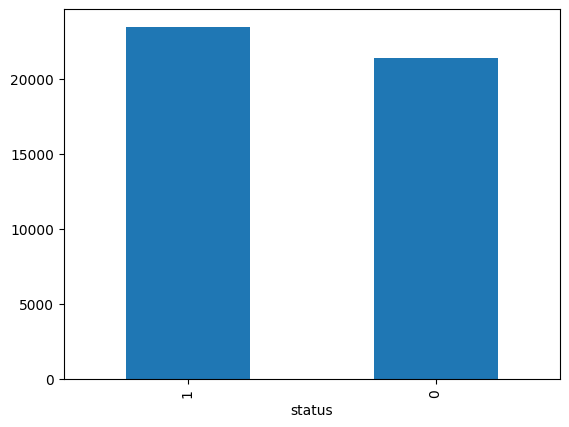

In [125]:
train_df.status.value_counts().plot(kind="bar")

### 1.2 Data Cleaning

In [126]:
train_df.drop_duplicates(inplace=True)
dataOverview(train_df)

Dataset Shape: (44689, 5)


,Name,dtypes,Missing,Uniques,Duplicates
0,title,object,0,38729,0
1,text,object,0,38646,0
2,subject,object,0,8,0
3,date,object,0,2397,0
4,status,int64,0,2,0


### 1.3 Data Transformation

In [127]:
train_df["title_length"] = train_df["title"].str.strip().apply(lambda title: len(title.split()))

train_df["text_length"] = train_df["text"].str.strip().apply(lambda text: len(text.split()))

In [128]:
dataOverview(train_df)

Dataset Shape: (44689, 7)


,Name,dtypes,Missing,Uniques,Duplicates
0,title,object,0,38729,0
1,text,object,0,38646,0
2,subject,object,0,8,0
3,date,object,0,2397,0
4,status,int64,0,2,0
5,title_length,int64,0,40,0
6,text_length,int64,0,1597,0


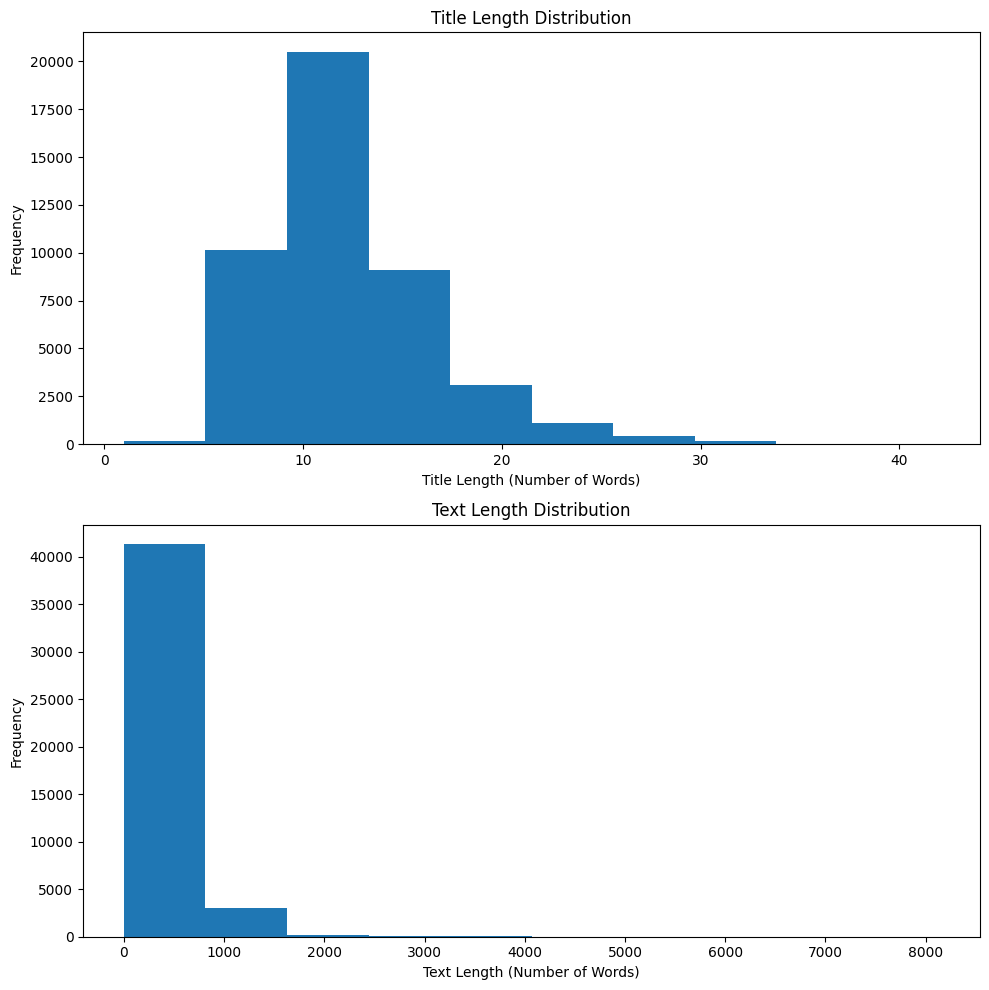

In [129]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
train_df["title_length"].plot(kind="hist")
plt.title("Title Length Distribution")
plt.xlabel("Title Length (Number of Words)")

plt.subplot(2, 1, 2)
train_df["text_length"].plot(kind="hist")
plt.title("Text Length Distribution")
plt.xlabel("Text Length (Number of Words)")
plt.tight_layout()
plt.show()

## Model Training

### 2.1 Splitting Dataset (Train & Validation Dataset)

In [130]:
train_data, valid_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["status"],
    random_state=42
)

print(train_data.shape, valid_data.shape)

(35751, 7) (8938, 7)


### 2.2 Dataset Creation

In [131]:
def create_dataset(dataframe, batch_size=128, shuffle=True, cache=True):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].astype(str), dataframe["status"].astype(int))
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=512, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    if cache:
        dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

### 2.3 Text Vectorization

In [132]:
def build_vectorizer(train_texts, vocab_size=5000, seq_length=256):
    vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=vocab_size,
        output_sequence_length=seq_length
    )
    text_ds = tf.data.Dataset.from_tensor_slices(train_texts.astype(str)).batch(512)
    vectorizer.adapt(text_ds)
    return vectorizer

### 2.4 Model Builder

In [133]:
def build_model(vectorizer, vocab_size=5000, embed_dim=16):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(), dtype=tf.string),
        vectorizer,
        tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            mask_zero=True
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(16, dropout=0.2, recurrent_dropout=0.1)
        ),
        tf.keras.layers.Dense(4, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model

### 2.5 Training

In [134]:
def train_model(model, train_ds, valid_ds, save_path="model.keras", epochs=10):
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=save_path,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        ),
        tf.keras.callbacks.EarlyStopping(
            patience=2,
            restore_best_weights=True,
            monitor='val_loss'
        )
    ]

    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=valid_ds,
        callbacks=callbacks
    )
    return history

In [135]:
if __name__ == "__main__":
    train_ds = create_dataset(train_data)
    valid_ds = create_dataset(valid_data, shuffle=False)

    vectorizer = build_vectorizer(train_data["text"])
    model = build_model(vectorizer)

    model.summary()

    history = train_model(model, train_ds, valid_ds, save_path="model.keras", epochs=10)

    best_model = tf.keras.models.load_model("model.keras")
    print("Model reloaded successfully!")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_11           │ (None, 256)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 256, 16)        │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 32)             │         4,224 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,361 (329.54 KB)

 Trainable params: 84,361 (329.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 45s 137ms/step - accuracy: 0.8252 - auc: 0.9213 - loss: 0.4164 - val_accuracy: 0.9977 - val_auc: 0.9999 - val_loss: 0.0263
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 34s 120ms/step - accuracy: 0.9710 - auc: 0.9943 - loss: 0.1051 - val_accuracy: 0.9984 - val_auc: 0.9998 - val_loss: 0.0194
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 33s 119ms/step - accuracy: 0.9732 - auc: 0.9954 - loss: 0.0886 - val_accuracy: 0.9990 - val_auc: 0.9997 - val_loss: 0.0151
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 35s 124ms/step - accuracy: 0.9730 - auc: 0.9953 - loss: 0.0816 - val_accuracy: 0.9987 - val_auc: 0.9993 - val_loss: 0.0162
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.9745 - auc: 0.9956 - loss: 0.0739 - val_accuracy: 0.9990 - val_auc: 0.9996 - val_loss: 0.0129
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 34s 121ms/step - accuracy: 0.9788 - auc: 0.9959 - loss: 0.0674 - val_accuracy: 0.9990 - val_auc: 0.9995 - val_loss: 0.0122
Epoch 7/10
280/280 ━━━

## Data Validation

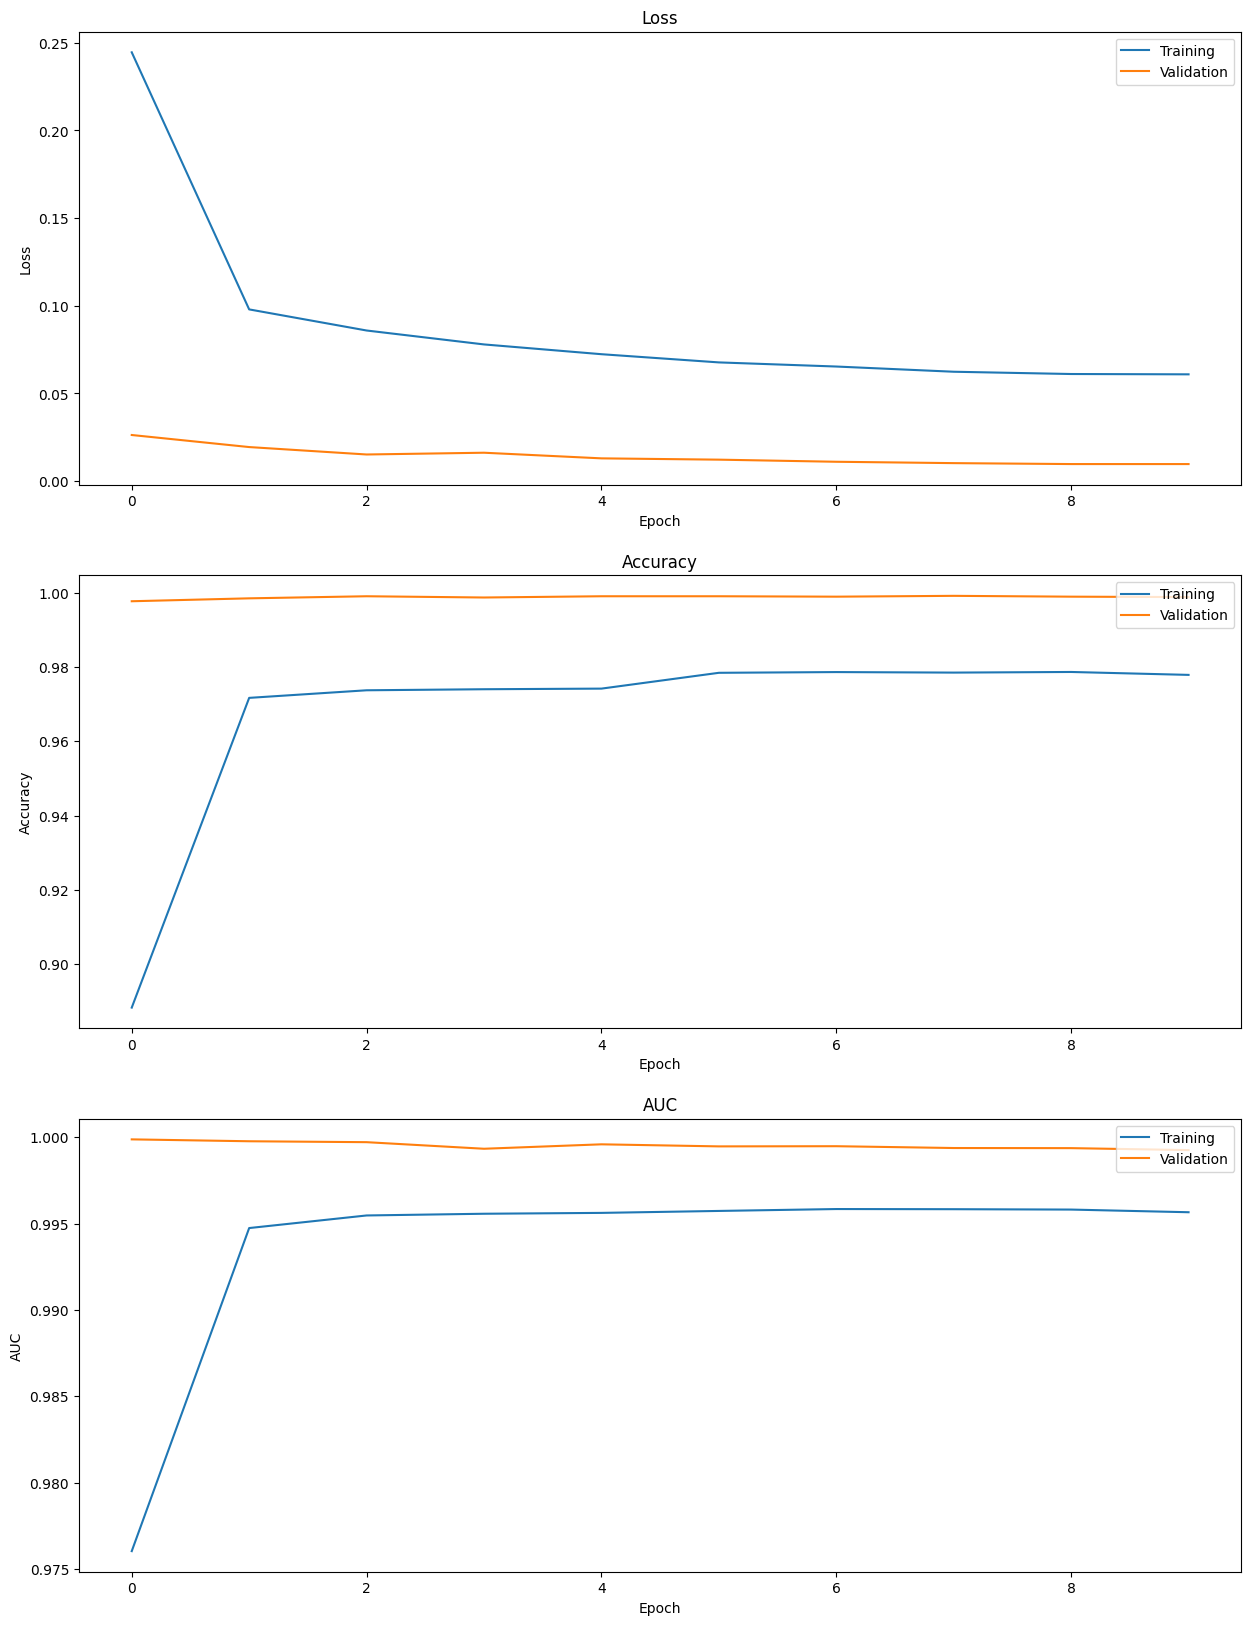

In [136]:
def plot_learning_curve(history):
  plt.figure(figsize=(15, 20))
  plt.subplot(3, 1, 1)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.subplot(3, 1, 2)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.subplot(3, 1, 3)
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('AUC')
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

plot_learning_curve(history)